In [ ]:
print SPARK_HOME

In [2]:
from pyspark import  SparkContext
sc = SparkContext( 'local', 'pyspark')

In [3]:
from pyspark.sql import HiveContext
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
from math import sqrt
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline


hiveContext = HiveContext(sc)

#Build a feature matrix
data = hiveContext.sql('select severity from boston_leaks')

#label.zip(scaler1.transform(features.map(lambda x: Vectors.dense(x.toArray()))))
parsedData = data.map(lambda x: Vectors.dense(x)).cache()
#val parsedData = data.map(x => Vectors.dense(x.split(',').map(_.toDouble))).cache()

print parsedData
summary = Statistics.colStats(parsedData)
print summary.mean()
print summary.variance()
print summary.numNonzeros()

PythonRDD[6] at RDD at PythonRDD.scala:43
[ 2.81981982]
[ 0.30222983]
[ 217.]


In [3]:
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 18.0


In [4]:
# No lets use the new Spark Data Frames in 1.3.x
# https://databricks.com/blog/2015/02/17/introducing-dataframes-in-spark-for-large-scale-data-science.html

# Constructs a DataFrame from the boston_leaks table in Hive.
leaks = hiveContext.table("boston_leaks")

# Create a new DataFrame that contains “low risk leaks” only
lowRisk = leaks.filter(leaks.severity < 3)

# Alternatively, using Pandas-like syntax
lowRisk = leaks[leaks.severity < 3]

# Increment the leak’s severity by 1
lowRisk.select(lowRisk.leak_no, lowRisk.severity + 1)

# Count the number of low risk leaks by days open
lowRisk.groupBy("days_open").count()

# Join young users with another DataFrame called logs
#young.join(logs, logs.userId == users.userId, "left_outer")

DataFrame[days_open: bigint, count: bigint]

In [5]:
# Convert Spark DataFrame to Pandas
pandas_df = lowRisk.toPandas()

# Create a Spark DataFrame from Pandas
spark_df = hiveContext.createDataFrame(pandas_df)

print pandas_df

                                               wkt  leak_no    wonum  \
0     POINT (-71.0771347637248 42.335619114067697)   269235   403711   
1   POINT (-71.101699881046116 42.342414338514445)   325036   685066   
2   POINT (-71.096736500825457 42.337606356914897)  1230025   919102   
3     POINT (-71.078340785188317 42.3366379410391)  1540329   966677   
4   POINT (-71.058741754347935 42.353288226082071)  1598457   976220   
5   POINT (-71.094876015347296 42.342861529452364)  1598504   976250   
6   POINT (-71.067760961153169 42.340848335392472)  1600664   976668   
7   POINT (-71.062516539443862 42.342842699545187)  1601476   976807   
8   POINT (-71.070498934883886 42.345932404251343)  1630947   982732   
9   POINT (-71.076461591489021 42.343093176929528)  1635977   983856   
10   POINT (-71.072999108936258 42.33325856025742)  1656871   987237   
11  POINT (-71.084176543744249 42.349162681976523)  1669623   990211   
12  POINT (-71.053384176904643 42.364019933217243)  1676878   99

In [6]:
x = pandas_df.severity
y = pandas_df.days_open

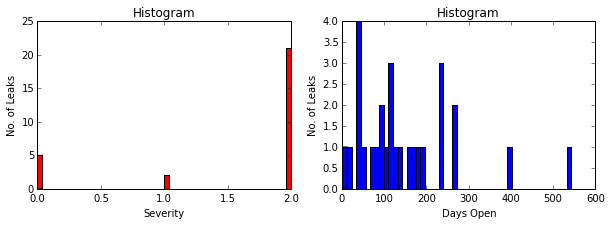

In [7]:
#fig = plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(10,3))

axes[0].hist(x, 50, facecolor='r')
axes[0].set_xlabel('Severity')
axes[0].set_ylabel('No. of Leaks')
axes[0].set_title('Histogram');

axes[1].hist(y, 50, facecolor='b')
axes[1].set_xlabel('Days Open')
axes[1].set_ylabel('No. of Leaks')
axes[1].set_title('Histogram');

In [109]:
def summarize(dataset):
    print "schema: %s" % dataset.schema().json()
    labels = dataset.map(lambda r: r.label)
    print "label average: %f" % labels.mean()
    features = dataset.map(lambda r: r.features)
    summary = Statistics.colStats(features)
    print "features average: %r" % summary.mean()

from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors

summarize(parsedData)



AttributeError: 'PipelinedRDD' object has no attribute 'schema'

In [ ]:
def isprime(n):
    """
    check if integer n is a prime
    """
    # make sure n is a positive integer
    n = abs(int(n))
    # 0 and 1 are not primes
    if n < 2:
        return False
    # 2 is the only even prime number
    if n == 2:
        return True
    # all other even numbers are not primes
    if not n & 1:
        return False
    # range starts with 3 and only needs to go up the square root of n
    # for all odd numbers
    for x in range(3, int(n**0.5)+1, 2):
        if n % x == 0:
            return False
    return True

# Create an RDD of numbers from 0 to 1,000,000
nums = sc.parallelize(xrange(1000000))

# Compute the number of primes in the RDD
print nums.filter(isprime).count()

In [112]:
myLines = sc.textFile('hdfs://sandbox.hortonworks.com/user/guest/Hortonworks')

In [113]:
myLines_filtered = myLines.filter( lambda x: len(x) > 0 )

In [114]:
myLines_filtered.count()

344

In [115]:
bostonLeaks = sc.textFile('hdfs://sandbox.hortonworks.com/user/hue/PROD_LEAKS.csv')

In [116]:
bostonLeaks.count()

296985

In [ ]:
from pyspark.mllib.stat import Statistics

# Compute column summary statistics.
summary = Statistics.colStats(bostonLeaks)
print summary.mean()
print summary.variance()
print summary.numNonzeros()